In [ ]:
!pip install --quiet pdetransformer

## Initialize PDE-S with pretrained weights from huggingface

In [4]:
from pdetransformer.core.mixed_channels import PDETransformer, SingleStepSupervised
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained model
model = PDETransformer.from_pretrained('thuerey-group/pde-transformer', subfolder='mc-s').to(device)
strategy = SingleStepSupervised(model)

## Load dataset

In [5]:
from pdetransformer.data import MultiDataModule

dataset = 'kolm_flow'
dataset_name = 'Kolmogorov Flow'
field = 'Vorticity'

params_data = {
    'path_index':
        {'2D_APE_xxl': './datasets'},
    'dataset_names': [ dataset ],
    'dataset_type': '2D_APE_xxl',
    'unrolling_steps': 1,
    'test_unrolling_steps': 29,
    'batch_size': 1,
    'num_workers': 1,
    'cache_strategy': 'none',
    'different_resolution_strategy': 'none',
    'normalize_data': 'mean-std',
    'normalize_const': 'mean-std',
    'downsample_factor': 1,
    'max_channels': 2,
}

data_module = MultiDataModule(**params_data)
data_module.setup(stage='test')
test_loader = data_module.test_dataloader()

download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%
Success: Loaded kolm_flow with 60 simulations and 29 samples each.
download completed	 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%
Success: Loaded kolm_flow_test with 5 simulations and 1 samples each.


In [6]:
data = next(iter(test_loader))
prediction, reference = strategy.predict(data, device=device, num_frames=29)

100%|██████████| 28/28 [00:30<00:00,  1.08s/it]


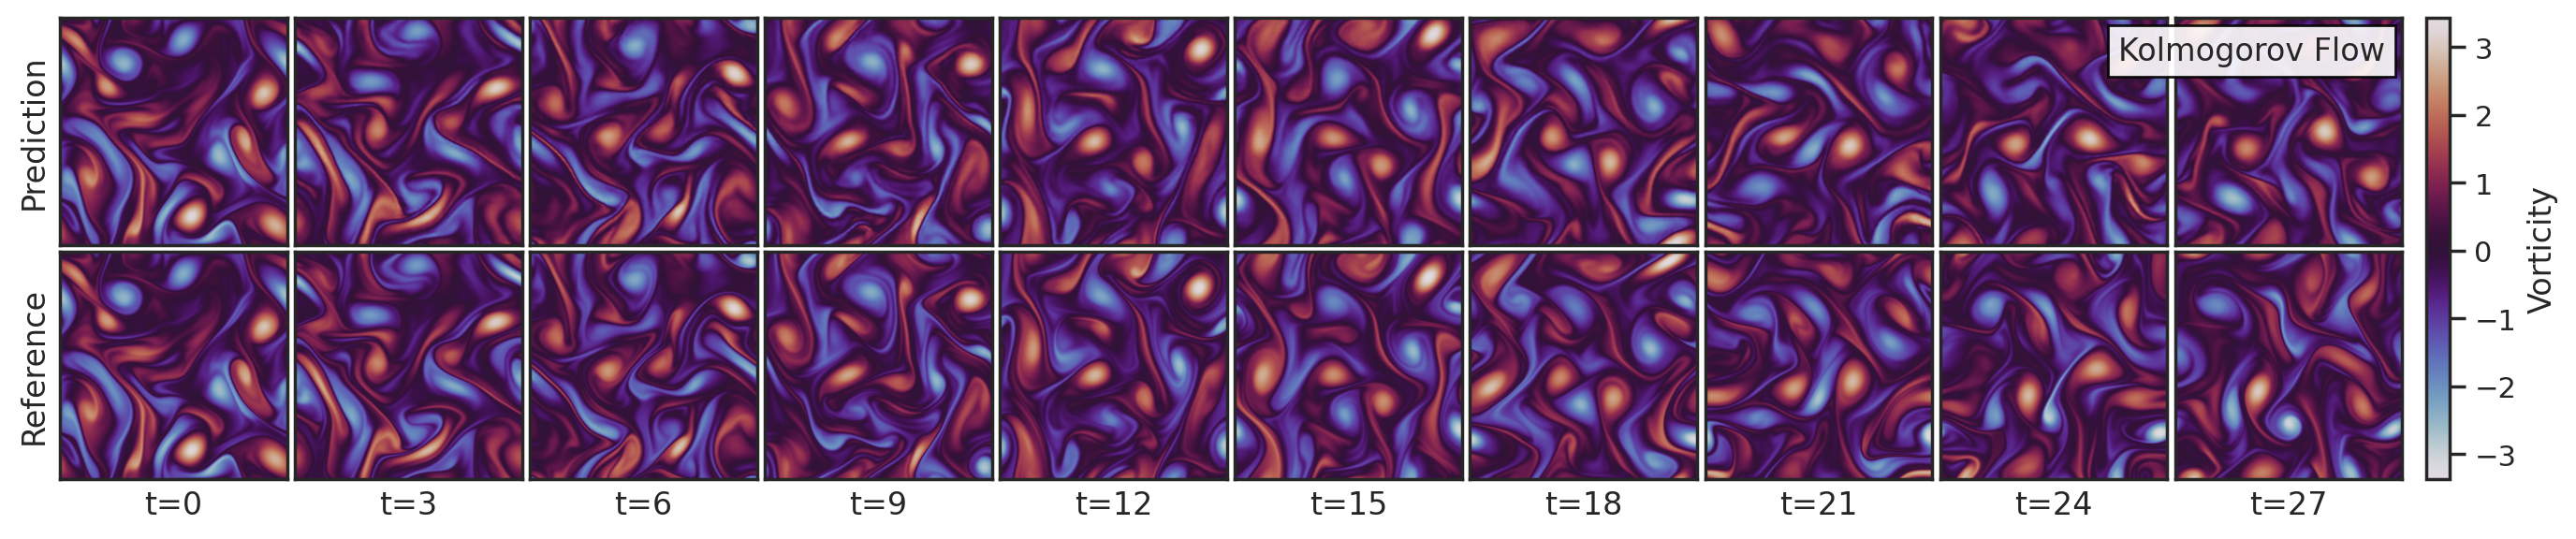

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

time_steps = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

prediction_steps = prediction[0, :, :, :]
reference_steps = reference[0, :, :, :]

sns.set_theme(style="white")
cmap = sns.color_palette("twilight", as_cmap=True)

fig, axes = plt.subplots(2, len(time_steps), figsize=(16.65,3.2), dpi=200)

vmin = reference_steps.min()
vmax = reference_steps.max()

for j, t in enumerate(time_steps):

    axes[0, j].imshow(prediction_steps[t][0],  cmap=cmap, vmin=vmin, vmax=vmax)

    axes[0, j].set_xticks([])
    axes[0, j].set_yticks([])

    axes[1, j].imshow(reference_steps[t][0], cmap=cmap,
                        vmin=vmin, vmax=vmax)

    axes[1, j].set_xticks([])
    axes[1, j].set_yticks([])

axes[0, 0].set_ylabel('Prediction', fontsize=12)
axes[1, 0].set_ylabel('Reference', fontsize=12)

for j, t in enumerate(time_steps):
    axes[1, j].set_xlabel(f't={t}', fontsize=12)

fig.text(0.8712, 0.85, f'{dataset_name}',
            fontsize=12, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'))

plt.subplots_adjust(wspace=0.03, hspace=0.03)

cbar = fig.colorbar(axes[0, 0].images[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label(field, fontsize=12)

plt.show()

## Model input for single step

In [9]:
input_0, input_1, labels = strategy.get_input(data)

In [10]:
labels

tensor([16])

Class label 16 corresponds to Kolmogorov flow

In [11]:
print('input_0: ', input_0.shape)
print('input_1: ', input_1.shape)

input_0:  torch.Size([1, 2, 256, 256])
input_1:  torch.Size([1, 29, 2, 256, 256])


We can also drop the class label and let the modle infer the type of PDE by itself

In [12]:
labels_unknown = torch.ones_like(labels) * 1000

In [13]:
with torch.no_grad():

    output_kolm_flow = model(
        hidden_states=input_0.to(device),
        class_labels=labels.to(device)
    )

    output_unknown = model(
        hidden_states=input_0.to(device),
        class_labels=labels_unknown.to(device)
    )

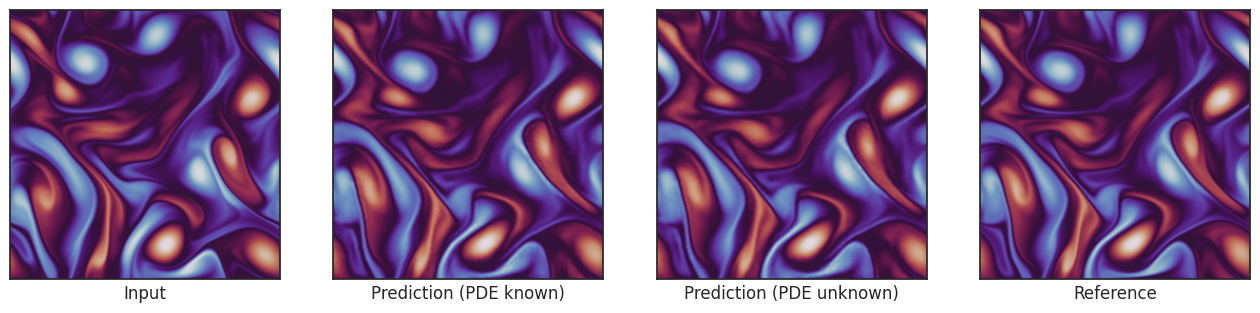

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

vmin = input_0.min()
vmax = input_1.max()

axes[0].imshow(input_0[0,0].numpy(), cmap='twilight')
axes[0].set_xlabel('Input')

axes[1].imshow(output_kolm_flow.sample[0,0].detach().cpu().numpy(), cmap='twilight')
axes[1].set_xlabel('Prediction (PDE known)')

axes[2].imshow(output_unknown.sample[0,0].detach().cpu().numpy(), cmap='twilight')
axes[2].set_xlabel('Prediction (PDE unknown)')

axes[3].imshow(input_1[0,0,0].numpy(), cmap='twilight')
axes[3].set_xlabel('Reference')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [20]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
class WaveEquation2D:
    """2D Wave equation simulator with reflective boundaries."""

    def __init__(self, grid_size=128, domain_size=1.0, c=1.0, dt=0.001):
        """
        Args:
            grid_size: Number of grid points in each direction
            domain_size: Physical size of domain
            c: Wave speed
            dt: Time step size
        """
        self.N = grid_size
        self.L = domain_size
        self.c = c
        self.dt = dt
        self.dx = domain_size / grid_size

        # CFL condition check
        self.cfl = c * dt / self.dx
        if self.cfl > 1.0 / np.sqrt(2):
            print(f"Warning: CFL condition violated! CFL = {self.cfl:.3f}")
        else:
            print(f"CFL = {self.cfl:.3f} (stable)")

        # State variables
        self.u_curr = np.zeros((grid_size, grid_size))  # Current displacement
        self.u_prev = np.zeros((grid_size, grid_size))  # Previous displacement
        self.time = 0.0

    def initialize_gaussian(self, center=(0.5, 0.5), sigma=0.05, amplitude=1.0):
        """Initialize with a Gaussian pulse."""
        x = np.linspace(0, self.L, self.N)
        y = np.linspace(0, self.L, self.N)
        X, Y = np.meshgrid(x, y)

        cx, cy = center
        self.u_curr = amplitude * np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))
        self.u_prev = self.u_curr.copy()

    def initialize_two_sources(self, centers=[(0.3, 0.5), (0.7, 0.5)],
                                sigma=0.05, amplitude=1.0):
        """Initialize with two Gaussian pulses for interference pattern."""
        x = np.linspace(0, self.L, self.N)
        y = np.linspace(0, self.L, self.N)
        X, Y = np.meshgrid(x, y)

        self.u_curr = np.zeros((self.N, self.N))
        for cx, cy in centers:
            self.u_curr += amplitude * np.exp(-((X - cx)**2 + (Y - cy)**2) / (2 * sigma**2))
        self.u_prev = self.u_curr.copy()

    def step(self):
        """Advance simulation by one time step using finite differences."""
        # Laplacian using 5-point stencil
        laplacian = np.zeros_like(self.u_curr)

        # Interior points
        laplacian[1:-1, 1:-1] = (
            self.u_curr[2:, 1:-1] + self.u_curr[:-2, 1:-1] +
            self.u_curr[1:-1, 2:] + self.u_curr[1:-1, :-2] -
            4 * self.u_curr[1:-1, 1:-1]
        ) / (self.dx ** 2)

        # Reflective boundary conditions (Neumann: du/dn = 0)
        # Left and right boundaries
        laplacian[0, :] = laplacian[1, :]
        laplacian[-1, :] = laplacian[-2, :]
        # Top and bottom boundaries
        laplacian[:, 0] = laplacian[:, 1]
        laplacian[:, -1] = laplacian[:, -2]

        # Update using leapfrog scheme
        u_next = 2 * self.u_curr - self.u_prev + (self.c * self.dt) ** 2 * laplacian

        # Update state
        self.u_prev = self.u_curr.copy()
        self.u_curr = u_next
        self.time += self.dt

        return self.u_curr.copy()

    def simulate(self, num_steps):
        """Run simulation for multiple steps."""
        trajectory = [self.u_curr.copy()]

        for _ in tqdm(range(num_steps), desc="Simulating wave equation"):
            u = self.step()
            trajectory.append(u)

        return np.array(trajectory)

In [25]:
# Simulation parameters
GRID_SIZE = 128
DOMAIN_SIZE = 1.0
WAVE_SPEED = 0.5
DT_SIM = 0.001  # Small timestep for accurate simulation
T_TOTAL = 5.0   # Total simulation time
NUM_STEPS = int(T_TOTAL / DT_SIM)

print(f"Simulation settings:")
print(f"  Grid size: {GRID_SIZE}x{GRID_SIZE}")
print(f"  Time step: {DT_SIM} s")
print(f"  Total time: {T_TOTAL} s")
print(f"  Number of steps: {NUM_STEPS}")

# Create simulator
wave_sim = WaveEquation2D(
    grid_size=GRID_SIZE,
    domain_size=DOMAIN_SIZE,
    c=WAVE_SPEED,
    dt=DT_SIM
)

# Initialize with a Gaussian pulse
wave_sim.initialize_gaussian(center=(0.5, 0.5), sigma=0.08, amplitude=1.0)

# Run simulation
gt_trajectory = wave_sim.simulate(NUM_STEPS)
print(f"\nGround truth trajectory shape: {gt_trajectory.shape}")

Simulation settings:
  Grid size: 128x128
  Time step: 0.001 s
  Total time: 5.0 s
  Number of steps: 5000
CFL = 0.064 (stable)


Simulating wave equation: 100%|██████████| 5000/5000 [00:01<00:00, 4197.98it/s]



Ground truth trajectory shape: (5001, 128, 128)


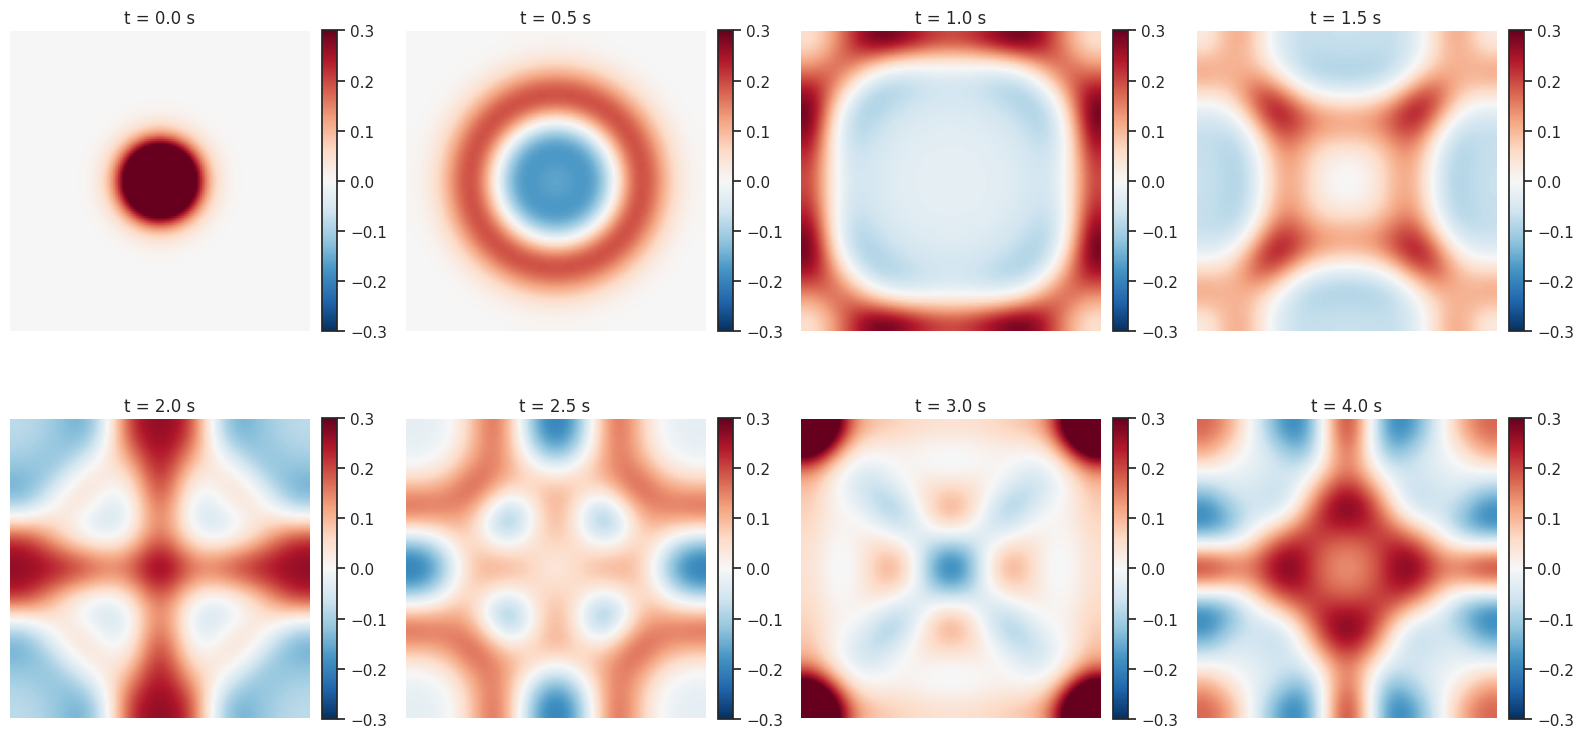

Ground truth wave propagation showing reflections at boundaries


In [26]:
# Plot snapshots at different times
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
times_to_plot = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
vmin, vmax = -0.3, 0.3

for ax, t in zip(axes.flat, times_to_plot):
    idx = int(t / DT_SIM)
    im = ax.imshow(gt_trajectory[idx], cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
    ax.set_title(f't = {t:.1f} s')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("Ground truth wave propagation showing reflections at boundaries")

In [43]:
# Model timestep (larger than simulation timestep)
DT_MODEL = 0.01  # 50 ms per step for the model
SKIP = int(DT_MODEL / DT_SIM)  # How many simulation steps per model step

print(f"Model timestep: {DT_MODEL} s")
print(f"Skipping every {SKIP} simulation frames")

# Downsample trajectory
gt_downsampled = gt_trajectory[::SKIP]
num_model_steps = len(gt_downsampled) - 2  # -2 because we need 2 frames to start

print(f"Downsampled trajectory shape: {gt_downsampled.shape}")
print(f"Number of model prediction steps: {num_model_steps}")

Model timestep: 0.01 s
Skipping every 10 simulation frames
Downsampled trajectory shape: (501, 128, 128)
Number of model prediction steps: 499


In [44]:
def normalize_data(data):
    """Normalize data to reasonable range for the model."""
    # Simple standardization
    mean = np.mean(data)
    std = np.std(data)
    if std > 0:
        return (data - mean) / std, mean, std
    return data, mean, 1.0

def denormalize_data(data, mean, std):
    """Denormalize data back to original range."""
    return data * std + mean

# Normalize the data
gt_normalized, data_mean, data_std = normalize_data(gt_downsampled)

print(f"Data statistics:")
print(f"  Mean: {data_mean:.4f}")
print(f"  Std: {data_std:.4f}")

Data statistics:
  Mean: 0.0409
  Std: 0.0987


In [45]:
@torch.no_grad()
def predict_trajectory_autoregressive(model, initial_frames, num_steps):
    """
    Autoregressively predict trajectory using the PDE-Transformer.

    Args:
        model: Pre-trained PDE-Transformer
        initial_frames: First 2 frames (2, H, W)
        num_steps: Number of steps to predict

    Returns:
        predictions: Array of shape (num_steps+2, H, W)
    """
    predictions = [initial_frames[0], initial_frames[1]]

    # Current input: last 2 frames
    current_input = torch.from_numpy(initial_frames).float().to(device)
    current_input = current_input.unsqueeze(0)  # Add batch dimension (1, 2, H, W)

    for step in tqdm(range(num_steps), desc="Model predictions"):
        # Predict next frame
        output = model(current_input)
        # Extract the actual tensor from the output object
        if hasattr(output, 'sample'):
            output_tensor = output.sample  # For diffusers models
        elif isinstance(output, dict):
            output_tensor = output['sample']  # Dict output
        else:
            output_tensor = output  # Already a tensor

        # Take the second channel (next timestep prediction)
        next_frame = output_tensor[0, 1].cpu().numpy()
        predictions.append(next_frame)

        # Update input: shift window by 1
        # Use last predicted frame and new prediction
        current_input = torch.stack([
            current_input[0, 1],  # Previous second frame becomes first
            output_tensor[0, 1]          # New prediction becomes second
        ]).unsqueeze(0)

    return np.array(predictions)

# Run autoregressive prediction
print("Running PDE-Transformer predictions...")
initial_frames = gt_normalized[:2]
model_predictions = predict_trajectory_autoregressive(
    model,
    initial_frames,
    num_model_steps
)

# Denormalize predictions
model_predictions = denormalize_data(model_predictions, data_mean, data_std)

print(f"Model predictions shape: {model_predictions.shape}")

Running PDE-Transformer predictions...


Model predictions: 100%|██████████| 499/499 [02:26<00:00,  3.40it/s]

Model predictions shape: (501, 128, 128)


In [46]:
# calculate MSE per frame and RMSE per frame
mse_per_frame = np.mean((gt_downsampled[:len(model_predictions)] - model_predictions)**2, axis=(1, 2))
rmse_per_frame = np.sqrt(mse_per_frame)

# Calculate normalized error (NRMSE)
gt_range = np.max(gt_downsampled) - np.min(gt_downsampled)
nrmse_per_frame = rmse_per_frame / gt_range

print(f"Error Statistics:")
print(f"  Mean RMSE: {np.mean(rmse_per_frame):.6f}")
print(f"  Mean NRMSE: {np.mean(nrmse_per_frame):.6f}")
print(f"  Final RMSE: {rmse_per_frame[-1]:.6f}")
print(f"  Final NRMSE: {nrmse_per_frame[-1]:.6f}")

Error Statistics:
  Mean RMSE: 0.258670
  Mean NRMSE: 0.193822
  Final RMSE: 0.241850
  Final NRMSE: 0.181219


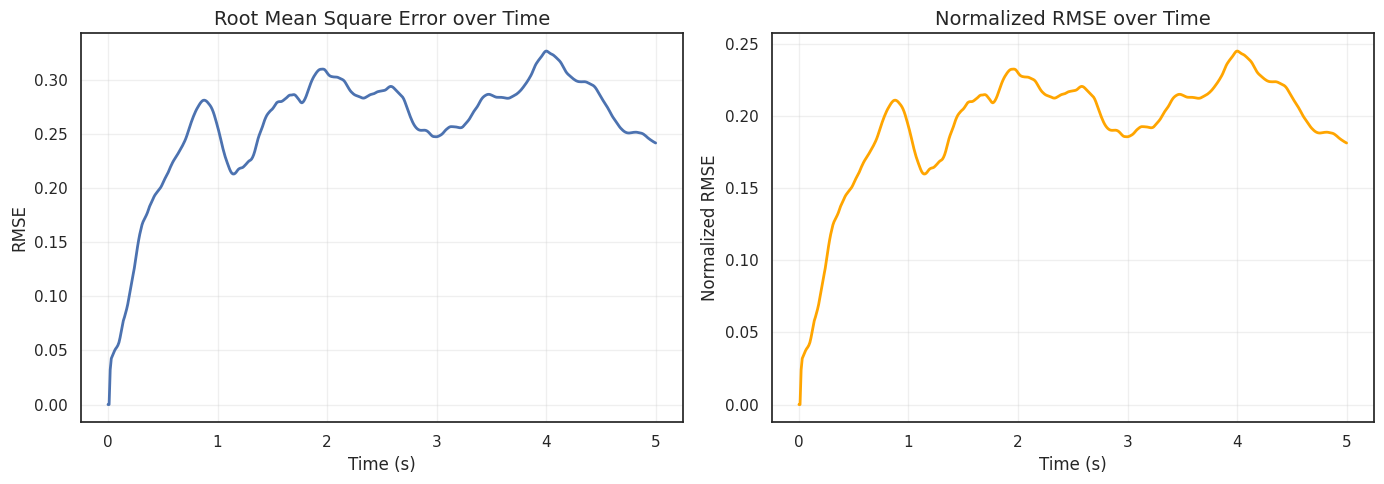

In [47]:
# Plot error as a function of time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

time_array = np.arange(len(mse_per_frame)) * DT_MODEL

ax1.plot(time_array, rmse_per_frame, linewidth=2)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_title('Root Mean Square Error over Time', fontsize=14)
ax1.grid(True, alpha=0.3)

ax2.plot(time_array, nrmse_per_frame, linewidth=2, color='orange')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Normalized RMSE', fontsize=12)
ax2.set_title('Normalized RMSE over Time', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

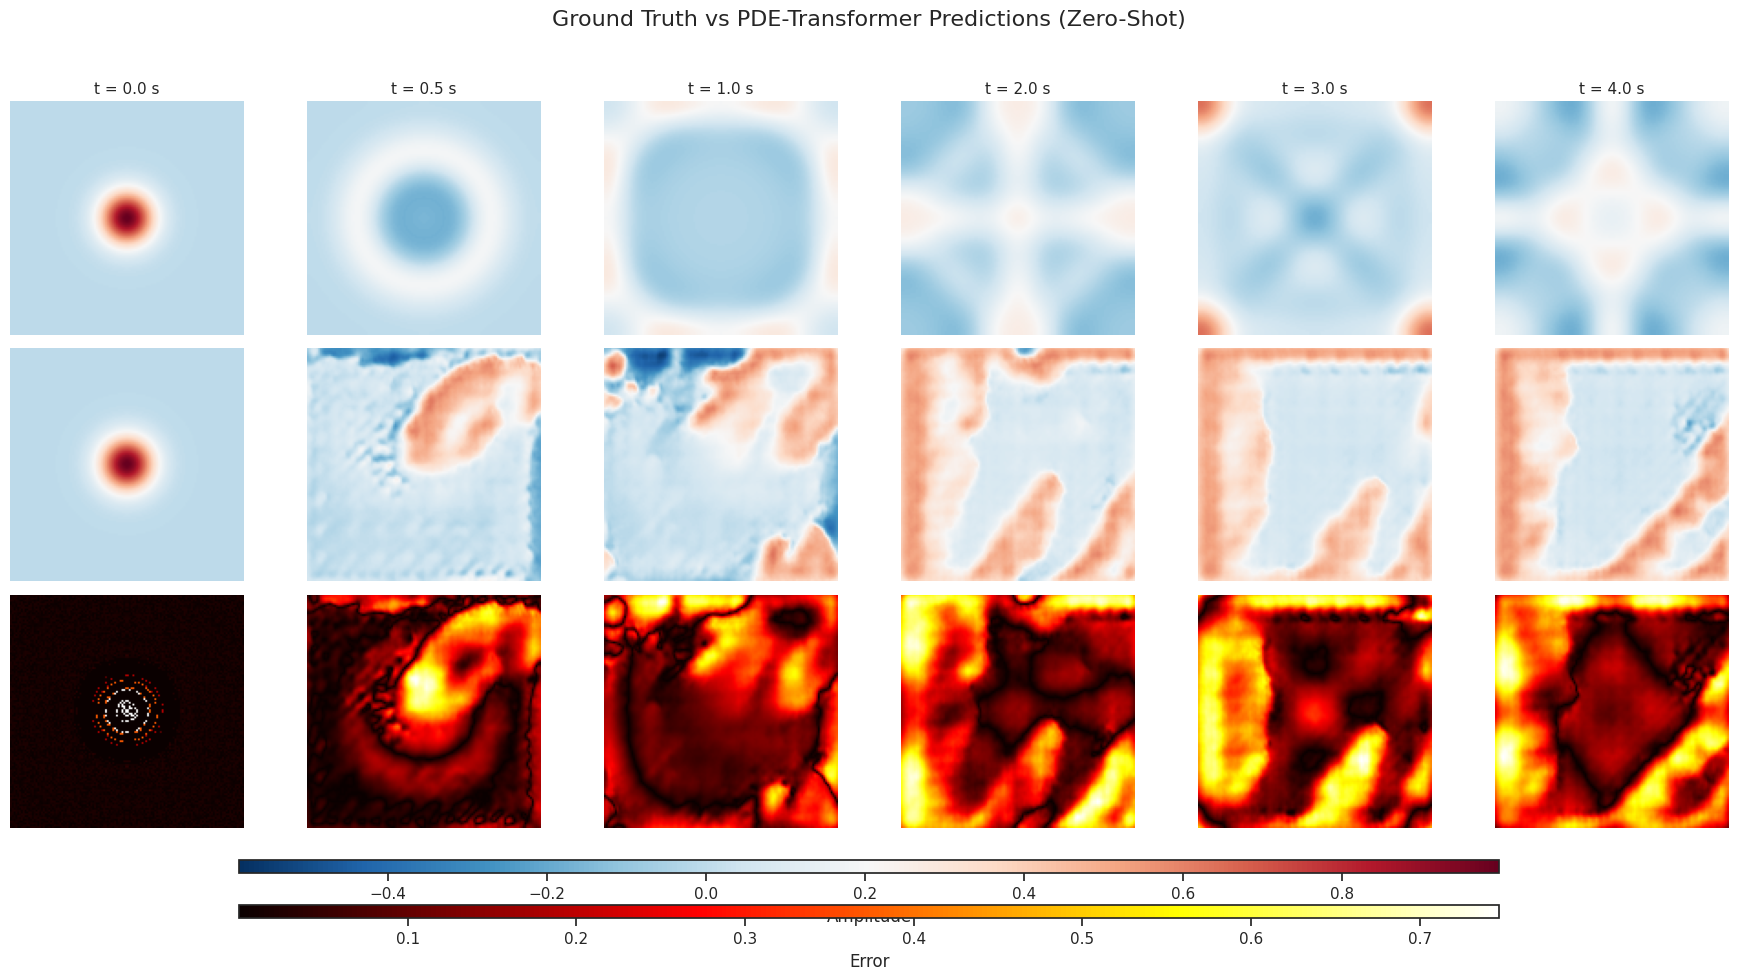

In [48]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot subplots at key points to compare them
# Visual comparison at key timepoints
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
times_to_compare = [0.0, 0.5, 1.0, 2.0, 3.0, 4.0]

# Find common color scale
vmin = min(gt_downsampled.min(), model_predictions.min())
vmax = max(gt_downsampled.max(), model_predictions.max())

for col, t in enumerate(times_to_compare):
    idx = int(t / DT_MODEL)
    if idx >= len(model_predictions):
        idx = len(model_predictions) - 1

    # Ground truth
    im = axes[0, col].imshow(gt_downsampled[idx], cmap='RdBu_r',
                              vmin=vmin, vmax=vmax, origin='lower')
    axes[0, col].set_title(f't = {t:.1f} s', fontsize=11)
    axes[0, col].axis('off')
    if col == 0:
        axes[0, col].set_ylabel('Ground Truth', fontsize=12, rotation=0,
                                 ha='right', va='center')

    # Model prediction
    axes[1, col].imshow(model_predictions[idx], cmap='RdBu_r',
                        vmin=vmin, vmax=vmax, origin='lower')
    axes[1, col].axis('off')
    if col == 0:
        axes[1, col].set_ylabel('Model Prediction', fontsize=12, rotation=0,
                                 ha='right', va='center')

    # Error
    error = np.abs(gt_downsampled[idx] - model_predictions[idx])
    im_err = axes[2, col].imshow(error, cmap='hot', origin='lower')
    axes[2, col].axis('off')
    if col == 0:
        axes[2, col].set_ylabel('Absolute Error', fontsize=12, rotation=0,
                                 ha='right', va='center')

plt.suptitle('Ground Truth vs PDE-Transformer Predictions (Zero-Shot)',
             fontsize=16, y=0.98)

# Adjust layout to make room for colorbars
plt.tight_layout(rect=[0, 0.05, 1, 0.96])

# Add colorbars at the bottom
cbar_ax1 = fig.add_axes([0.15, 0.02, 0.7, 0.015])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax1, orientation='horizontal', label='Amplitude')

cbar_ax2 = fig.add_axes([0.15, -0.03, 0.7, 0.015])
fig.colorbar(im_err, cax=cbar_ax2, orientation='horizontal', label='Error')

plt.show()

In [ ]:
# Create side by side animation